### Desafío Práctico
### MIA Algoritmos Evolutivos I (2025)   
Alumno: Jorge Heyul Chavez Arias

Docente: Esp. Ing. Miguel Augusto Azar


Tema: Selección de características para un modelo de clasificación usando algoritmos genéticos.

Objetivo: Identificar el sexo a partir de una grafica de espirometria. Para esto se utilizará modelos de Machine Learning, extracción de características, y optimización del uso de características para mejorar la predicción.  

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tsfel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

PATH_DEMO   = "demographics_data.csv"  
PATH_CURVES = "spirotidydatafinal.txt"     

def to_seconds(t):
    t = np.asarray(t, dtype=float)
    if np.nanmax(t) > 50:  #  
        t = t / 1000.0
    t = t - np.nanmin(t)
    return t

def pick_one_trial_per_id(curves_df):
    
    curves_df = curves_df.sort_values(["Id", "Visit", "Trial", "Time"])
    # elegir primera combinación (Visit, Trial) por ID
    first_keys = curves_df.groupby(["Id", "Visit", "Trial"], as_index=False).size()
    best = first_keys.sort_values(["Id", "Visit", "Trial"]).groupby("Id", as_index=False).first()
    return best[["Id","Visit","Trial"]]

demo = pd.read_csv(PATH_DEMO)
demo.columns = [c.strip().upper() for c in demo.columns]
assert "ID" in demo.columns and "SEX" in demo.columns, "demografia.csv debe tener 'ID' y 'SEX'"

curves = pd.read_csv(PATH_CURVES)
curves.columns = [c.strip().capitalize() for c in curves.columns]
needed = {"Id","Visit","Trial","Time","Volume","Flow"}
assert needed.issubset(set(curves.columns)), f"curvas.txt debe tener columnas {needed}"

#demo.head(), curves.head()


In [45]:
#   ID , Flow–Time, sex
sel = pick_one_trial_per_id(curves)
df_list = []

for _, r in sel.iterrows():
    pid, v, tr = int(r["Id"]), int(r["Visit"]), int(r["Trial"])
    g = curves[(curves["Id"]==pid) & (curves["Visit"]==v) & (curves["Trial"]==tr)].sort_values("Time")

    t = to_seconds(g["Time"].values)
    f = g["Flow"].values.astype(float)
 
    if (f >= 0).sum() < 5:
        f = -f
    m = f >= 0
    if m.sum() < 5: 
        tt, ff = t, f
    else:
        tt, ff = t[m], f[m]
        tt = tt - tt[0]   

    if len(tt) > 3:
        dt = np.median(np.diff(tt))
        fs = 1.0 / dt if dt > 0 else 100.0  
        n_points = int(np.clip(round(tt[-1] * fs) + 1, 50, 4000))
        t_uni = np.linspace(0, tt[-1], n_points)
        f_uni = np.interp(t_uni, tt, ff)
    else:
        t_uni, f_uni = tt, ff
        fs = 100.0

    df_list.append({
        "ID": pid,
        "time": t_uni, 
        "flow": f_uni,  
        "fs": fs
    })

df_flow = pd.DataFrame(df_list).merge(demo[["ID","SEX"]], on="ID", how="left")

print(df_flow.shape)
df_flow.head()


(129, 5)


,ID,time,flow,fs,SEX
0,101,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.04125, 0.07125, 0.1125, 0.1475, 0.16812, 0....",100.0,Female
1,102,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.08125, 0.1525, 0.235, 0.31125, 0.3875, 0.45...",100.0,Male
2,103,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.18375, 0.35187, 0.54062, 0.73437, 0.92312, ...",100.0,Female
3,104,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.32625, 0.84625, 1.5606, 2.4631, 3.5956, 5.0...",100.0,Male
4,105,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...",100.0,Female


,SEX,count
0,Female,90
1,Male,39


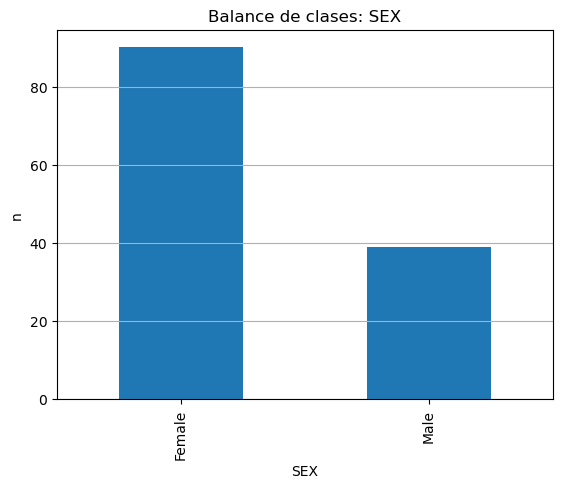

In [46]:
sex_counts = df_flow["SEX"].value_counts(dropna=False).rename_axis("SEX").reset_index(name="count")
display(sex_counts)

plt.figure()
sex_counts.set_index("SEX")["count"].plot(kind="bar")
plt.title("Balance de clases: SEX")
plt.ylabel("n")
plt.grid(True, axis="y")
plt.show()


In [ ]:
#Balanceo de datos
df_valid = df_flow.dropna(subset=["SEX"]).copy()

# Tomar 39 aleatorios de cada clase
n = 39
male_df = df_valid[df_valid["SEX"] == "Male"].sample(n=n, random_state=42)
female_df = df_valid[df_valid["SEX"] == "Female"].sample(n=n, random_state=42)

# Unir y mezclar
df_balanced = pd.concat([male_df, female_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Reemplazar df_flow por el balanceado para el resto del notebook
df_flow = df_balanced.copy()

# Verificar balance
print(df_flow["SEX"].value_counts())



SEX
Male      39
Female    39
Name: count, dtype: int64


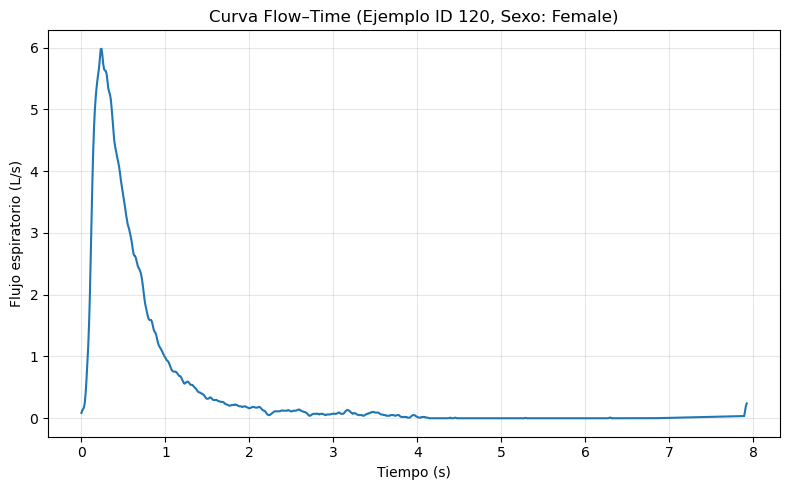

In [48]:
import matplotlib.pyplot as plt
import numpy as np

#  Muestra grafica de espirometria
example_id = df_flow.sample(1, random_state=42).iloc[0]["ID"]
row = df_flow[df_flow["ID"] == example_id].iloc[0]

t = np.array(row["time"])
f = np.array(row["flow"])

plt.figure(figsize=(8,5))
plt.plot(t, f,  )
plt.title(f"Curva Flow–Time (Ejemplo ID {example_id}, Sexo: {row['SEX']})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Flujo espiratorio (L/s)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


c:\Users\heyul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


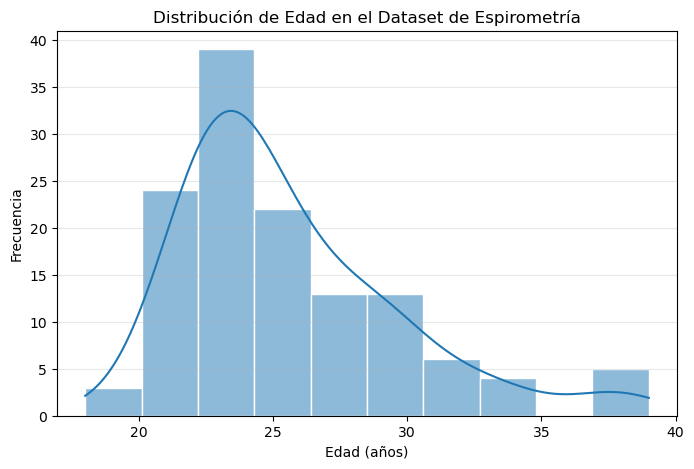

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset demográfico
demo = pd.read_csv(PATH_DEMO)
demo.columns = [c.strip().upper() for c in demo.columns]

plt.figure(figsize=(8,5))
sns.histplot(demo["AGE"], bins=10, kde=True, edgecolor="white")
plt.title("Distribución de Edad en el Dataset de Espirometría")
plt.xlabel("Edad (años)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)
#plt.tight_layout()
plt.show()

#print("Resumen estadístico de la edad:")
#display(demo["AGE"].describe())


In [ ]:
# Extraccion de caracteristicas
# Config TSFEL: unir temporal y estadístico
cfg_tem = tsfel.get_features_by_domain("temporal")
cfg_stat = tsfel.get_features_by_domain("statistical")
 
cfg = {}
cfg.update(cfg_tem)
cfg.update(cfg_stat)
 
len(cfg)

# Todas las domains (temporal+estadístico+espectral+…)
#cfg = tsfel.get_features_by_domain()
#len(cfg)

2

In [51]:
# Extracción de features por ID (solo Flow)
feat_rows = []

for _, row in df_flow.iterrows():
    pid = int(row["ID"])
    flow = row["flow"]
    fs   = float(row["fs"])

    signal_df = pd.DataFrame({"flow": flow})

    feats = tsfel.time_series_features_extractor(
        cfg, signal_df, fs=fs, window_size=None, verbose=0
    ) 
    feats["ID"] = pid
    feat_rows.append(feats.iloc[0])

features_df = pd.DataFrame(feat_rows)

features_df = features_df.replace([np.inf, -np.inf], np.nan)
valid_cols = features_df.columns[features_df.isna().mean() < 0.3]  # permite hasta 30% NaN
features_df = features_df[valid_cols]
features_df = features_df.dropna(axis=1, how="all")  # columnas totalmente vacías
features_df.shape


(78, 46)

In [52]:
# Dataset final: SEX + features
dataset = df_flow[["ID","SEX"]].merge(features_df, on="ID", how="inner")

# target binario  
dataset["SEX_BIN"] = dataset["SEX"].map({"Female":0, "Male":1})

print(dataset.shape)
dataset.head()


(78, 48)


,ID,SEX,flow_Absolute energy,flow_Area under the curve,flow_Autocorrelation,flow_Average power,flow_Centroid,flow_ECDF Percentile Count_0,flow_ECDF Percentile Count_1,flow_ECDF Percentile_0,...,flow_Positive turning points,flow_Root mean square,flow_Signal distance,flow_Skewness,flow_Slope,flow_Standard deviation,flow_Sum absolute diff,flow_Variance,flow_Zero crossing rate,SEX_BIN
0,158,Male,3380.389666,6.236814,50.0,425.741772,0.282542,159.0,636.0,0.030625,...,25.0,2.062053,801.091117,3.563763,-0.004763,1.906772,29.16127,3.635779,14.0,1
1,201,Male,2012.654403,4.119347,38.0,234.575105,0.384448,171.0,687.0,0.019516,...,21.0,1.530693,862.655248,4.228078,-0.002728,1.453623,25.22297,2.113019,14.0,1
2,163,Male,3245.598969,5.922435,50.0,340.924261,0.461341,190.0,762.0,0.030625,...,14.0,1.845444,956.742323,3.786966,-0.003137,1.737636,23.87450,3.019380,2.0,1
3,153,Male,2715.354938,4.879761,36.0,298.718915,0.363346,182.0,728.0,0.005000,...,28.0,1.727399,912.624019,4.093222,-0.002991,1.642013,21.33993,2.696206,0.0,1
4,157,Male,2036.381676,4.098915,35.0,237.340522,0.266784,171.0,687.0,0.000000,...,17.0,1.539689,862.570788,4.442517,-0.002875,1.463828,22.92642,2.142793,14.0,1


In [53]:
#  Entrenamiento  (Logistic Regression)
exclude = {"ID","SEX","SEX_BIN"}
feature_cols = [c for c in dataset.columns if c not in exclude]

df_train = dataset.dropna(subset=["SEX_BIN"] + feature_cols).copy()
X = df_train[feature_cols].values
y = df_train["SEX_BIN"].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),   
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])

pipe.fit(X_tr, y_tr)
y_pred = pipe.predict(X_te)

print("Accuracy:", accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred, target_names=["Female","Male"]))


Accuracy: 0.75
              precision    recall  f1-score   support

      Female       0.78      0.70      0.74        10
        Male       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



In [54]:
#importancia de variables

clf = pipe.named_steps["clf"]
coef = clf.coef_.ravel()
feature_names = feature_cols 

# Crear un DataFrame ordenado
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coeficiente": coef,
    "Importancia Absoluta": np.abs(coef)
}).sort_values("Importancia Absoluta", ascending=False)

coef_df.head(15)

,Feature,Coeficiente,Importancia Absoluta
30,flow_Median absolute diff,0.754123,0.754123
44,flow_Zero crossing rate,0.685319,0.685319
2,flow_Autocorrelation,0.568698,0.568698
21,flow_Interquartile range,-0.553685,0.553685
22,flow_Kurtosis,0.535236,0.535236
19,flow_Entropy,0.510010,0.510010
4,flow_Centroid,0.407421,0.407421
25,flow_Mean absolute deviation,0.341695,0.341695
34,flow_Neighbourhood peaks,-0.313993,0.313993
24,flow_Mean,0.298535,0.298535


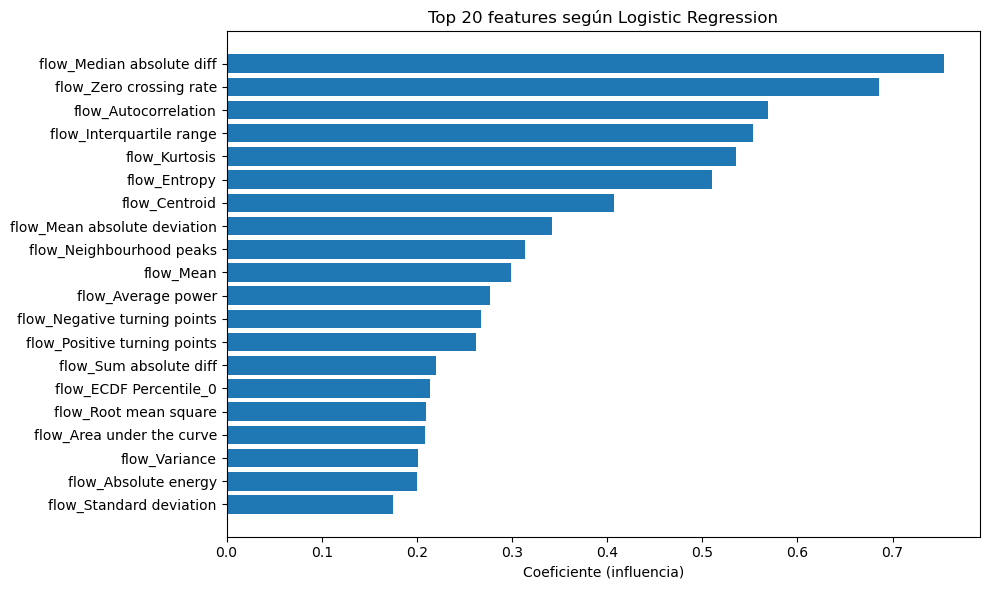

In [55]:
import matplotlib.pyplot as plt

top_n = 20  # muestra los 20 más importantes
top_df = coef_df.head(top_n).sort_values("Importancia Absoluta")

plt.figure(figsize=(10,6))
plt.barh(top_df["Feature"], top_df["Importancia Absoluta"], ) #color=np.where(top_df["Coeficiente"]>0, 'tab:red', 'tab:blue')
#plt.axvline(0, color='gray', lw=1)
plt.xlabel("Coeficiente (influencia)")
plt.title(f"Top {top_n} features según Logistic Regression") #\n(Rojo → favorece 'Male', Azul → 'Female')
plt.tight_layout()
plt.show()



Mejor k: 8  |  Accuracy: 0.750
Features seleccionados:
 - flow_Median absolute diff
 - flow_Zero crossing rate
 - flow_Autocorrelation
 - flow_Interquartile range
 - flow_Kurtosis
 - flow_Entropy
 - flow_Centroid
 - flow_Mean absolute deviation

=== Reporte con el mejor subconjunto ===
Accuracy: 0.75
              precision    recall  f1-score   support

      Female       1.00      0.50      0.67         8
        Male       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16



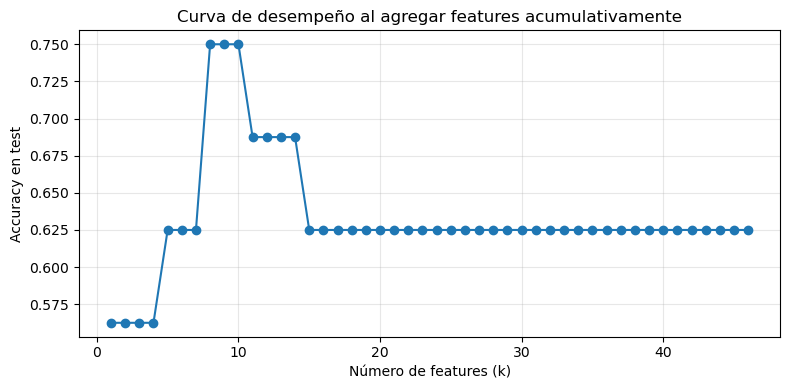

In [ ]:
# Optimizacion manual, se toma los features mas relevantes 
ordered_features = [
    "flow_Median absolute diff",
    "flow_Zero crossing rate",
    "flow_Autocorrelation",
    "flow_Interquartile range",
    "flow_Kurtosis",
    "flow_Entropy",
    "flow_Centroid",
    "flow_Mean absolute deviation",
    "flow_Neighbourhood peaks",
    "flow_Mean",
    "flow_Average power",
    "flow_Negative turning points",
    "flow_Positive turning points",
    "flow_Sum absolute diff",
    "flow_ECDF Percentile_0",
    "flow_ECDF Percentile_0", 
    "flow_Root mean square", 
    "flow_Area under the curve", 
    "flow_Variance",  
    "flow_Absolute energy", 
    "flow_Standard deviation",  
    "flow_Skewness",  
    "flow_Histogram mode",  
    "flow_Max",  
    "flow_Peak to peak distance", 
    "flow_Slope", 
    "flow_Mean absolute diff", 
    "flow_Median", 
    "flow_Mean diff",
    "flow_ECDF_4",
    "flow_ECDF_9",
    "flow_ECDF_6", 
    "flow_ECDF_8",
    "flow_ECDF_2", 
    "flow_ECDF_5", 
    "flow_ECDF_3", 
    "flow_ECDF_7", 
    "flow_ECDF_1", 
    "flow_ECDF_0", 
    "flow_ECDF Percentile_1", 
    "flow_Median diff", 
    "flow_Median absolute deviation", 
    "flow_Min", 
    "flow_ECDF Percentile Count_1", 
    "flow_Signal distance", 
    "flow_ECDF Percentile Count_0",  
]

exclude = {"ID","SEX","SEX_BIN"}
available = [c for c in ordered_features if c in dataset.columns]
missing = [c for c in ordered_features if c not in dataset.columns]
 
cols_use = available
df_train = dataset.dropna(subset=["SEX_BIN"] + cols_use).copy()

X_df = df_train[cols_use].copy()
y = df_train["SEX_BIN"].values
 
from sklearn.model_selection import train_test_split
X_tr_df, X_te_df, y_tr, y_te = train_test_split(
    X_df, y, test_size=0.20, random_state=9, stratify=y
)
  
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced")),
])

# agregar features acumulativamente y medir accuracy
results = []
for k in range(1, len(cols_use) + 1):
    subset = cols_use[:k]
    pipe.fit(X_tr_df[subset], y_tr)
    y_pred = pipe.predict(X_te_df[subset])
    acc = accuracy_score(y_te, y_pred)
    results.append({"k": k, "accuracy": acc, "features": subset})

# tabla de resultados ordenada por k y por accuracy
res_df = pd.DataFrame(results)[["k","accuracy"]]
#display(res_df)

best_idx = int(res_df["accuracy"].idxmax())
best_k = int(res_df.loc[best_idx, "k"])
best_acc = float(res_df.loc[best_idx, "accuracy"])
best_features = results[best_idx]["features"]

print(f"\nMejor k: {best_k}  |  Accuracy: {best_acc:.3f}")
print("Features seleccionados:")
for f in best_features:
    print(" -", f)

# Entrenar y reportar con el mejor subconjunto
pipe.fit(X_tr_df[best_features], y_tr)
y_pred = pipe.predict(X_te_df[best_features])
print("\n=== Reporte con el mejor subconjunto ===")
print("Accuracy:", accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred, target_names=["Female","Male"]))

# Gráfico Accuracy vs Número de features
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(res_df["k"], res_df["accuracy"], marker="o")
plt.xlabel("Número de features (k)")
plt.ylabel("Accuracy en test")
plt.title("Curva de desempeño al agregar features acumulativamente")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [57]:
# Optimizacion por GA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepara X e y
exclude = {"ID","SEX","SEX_BIN"}
feature_cols = [c for c in dataset.columns if c not in exclude]
X = dataset[feature_cols].fillna(0).values
y = dataset["SEX_BIN"].values

# Escalado previo (mejor estabilidad en evaluación)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo base
base_model = LogisticRegression(max_iter=300, class_weight="balanced")

# Evaluación  
score = np.mean(cross_val_score(base_model, X_scaled, y, cv=20))
print(f"Baseline CV Accuracy: {score:.3f}")


Baseline CV Accuracy: 0.713


In [58]:
#Definir función de fitness para el GA
import pygad
from sklearn.model_selection import cross_val_score

def fitness_func(ga_instance, solution, solution_idx):
  
    mask = np.array(solution, dtype=bool)
    n_selected = mask.sum()
    if n_selected == 0:
        return 0.0  # sin features 

    X_sel = X_scaled[:, mask]
    
    # Validación cruzada  
    try:
        scores = cross_val_score(base_model, X_sel, y, cv=10)
        mean_score = np.mean(scores)
    except Exception:
        mean_score = 0  

    # Penalización por usar muchos features. en este caso sin penzalizacion
    penalty = 0.00 * (n_selected / len(mask))

    return mean_score - penalty

In [59]:
#Configurar y ejecutar el algoritmo genético
num_features = X_scaled.shape[1]

ga = pygad.GA(
    num_generations=100,
    num_parents_mating=15, #cuantos padres a reproducirse
    fitness_func=fitness_func,    
    sol_per_pop=40,        # individuos por generacion 
    num_genes=num_features,
    init_range_low=0,
    init_range_high=1,
    gene_type=int,
    mutation_type="random",
    mutation_percent_genes=10,
    crossover_type="single_point",
    keep_parents=1,
    parent_selection_type="sss", #Steady-State Selection
    stop_criteria=["saturate_10"]
)

ga.run()

In [60]:
#Celda 4 — Resultados y subconjunto óptimo
solution, solution_fitness, _ = ga.best_solution()
mask = np.array(solution, dtype=bool)
selected_features = np.array(feature_cols)[mask]

print(f"\nMejor fitness: {solution_fitness:.3f}")
print(f"Features seleccionados ({mask.sum()}/{len(mask)}):")
for f in selected_features:
    print(" -", f)



Mejor fitness: 0.855
Features seleccionados (16/45):
 - flow_Average power
 - flow_Interquartile range
 - flow_Kurtosis
 - flow_Max
 - flow_Mean absolute diff
 - flow_Median absolute diff
 - flow_Median diff
 - flow_Min
 - flow_Neighbourhood peaks
 - flow_Peak to peak distance
 - flow_Skewness
 - flow_Slope
 - flow_Standard deviation
 - flow_Sum absolute diff
 - flow_Variance
 - flow_Zero crossing rate


In [61]:
mask

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True, False, False,  True,
       False, False, False,  True,  True,  True, False,  True,  True,
       False, False, False,  True,  True,  True,  True,  True,  True])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


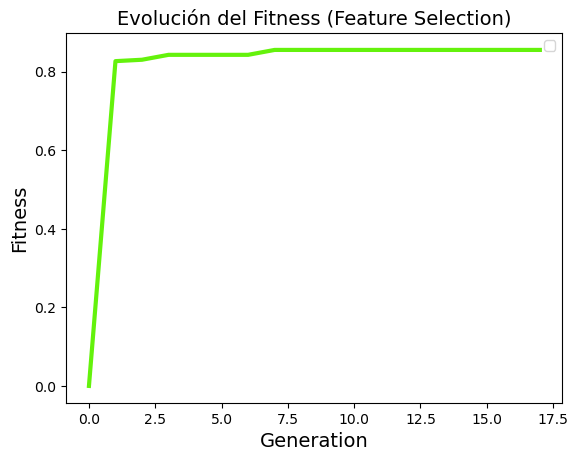

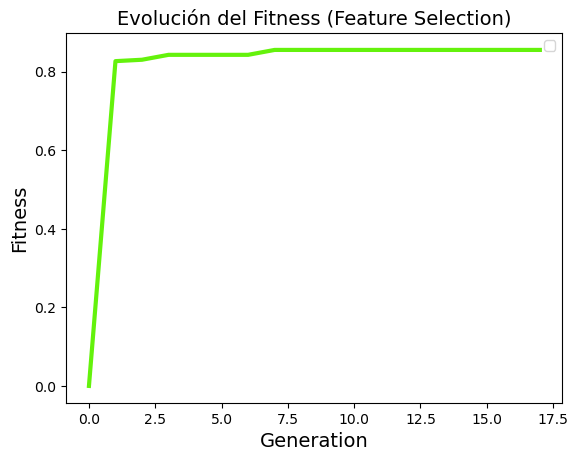

In [63]:
ga.plot_fitness(title="Evolución del Fitness (Feature Selection)")